In [1]:
import pandas as pd
import numpy as np
import torch
import torchvision
from torchvision import transforms,datasets
from torch.utils.data import DataLoader, TensorDataset,random_split
import os
import helper
from PIL import Image
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
torch.set_grad_enabled(True)


In [2]:
def prep_dataloader(root_path,batch_size):
    labels=os.listdir(root_path)
    x_val=[]
    min_ht=99999999         #used to store minimum height of the images
    min_wd=99999999         # used to store maximum height of the images
    print("Labels are:",labels)
    for label in labels:
        os.chdir(root_path+label+"/")
        files=os.listdir(root_path+label+"/")
        transform=transforms.ToTensor()
        for f in files:
            img=Image.open(f)    
            img=transform(img)
            min_ht=min(min_ht,img.shape[1])
            min_wd=min(min_wd,img.shape[2])
            x_val.append(img)
        
    mean_ch1=torch.mean(x_val[:][0])
    mean_ch2=torch.mean(x_val[:][1])
    mean_ch3=torch.mean(x_val[:][2])
    sd_ch1=torch.std(x_val[:][0])
    sd_ch2=torch.std(x_val[:][1])
    sd_ch3=torch.std(x_val[:][2])
    transform=transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(mean_ch1,mean_ch2,mean_ch3),std=(sd_ch1,sd_ch2,sd_ch3))
    ])
    print("MIN_HT",min_ht)
    print("MIN_WD",min_wd)
    dataset=datasets.ImageFolder(root=root_path,transform=transform)
    print("Number of datapoints:",len(dataset))
    print("The class labels are mapped as: ",dataset.class_to_idx)
    train,test=random_split(dataset,[5520,1379])
    train_loader=DataLoader(dataset=train,batch_size=batch_size,shuffle=True)
    test_loader=DataLoader(dataset=test,batch_size=batch_size,shuffle=True)
    return (train_loader,test_loader)

In [3]:
train_loader,test_loader=prep_dataloader("/home/samsepi0l/Datasets/data/natural_images/",5) # pass in the absolute path to root dataset here 
bat=next(iter(train_loader))
img,labl=bat
print("Shape of image per batch:",img.shape)
print("Shape of labels per batch:",labl.shape)


Labels are: ['person', 'cat', 'motorbike', 'flower', 'fruit', 'airplane', 'car', 'dog']
MIN_HT 50
MIN_WD 43
Number of datapoints: 6899
The class labels are mapped as:  {'airplane': 0, 'car': 1, 'cat': 2, 'dog': 3, 'flower': 4, 'fruit': 5, 'motorbike': 6, 'person': 7}
Shape of image per batch: torch.Size([5, 3, 32, 32])
Shape of labels per batch: torch.Size([5])


In [4]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,padding=(1,1))
        self.conv2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=(1,1))
        self.fc1=nn.Linear(in_features=32*8*8,out_features=180)
        self.fc2=nn.Linear(in_features=180,out_features=60)
        self.out=nn.Linear(in_features=60,out_features=8)
        
    def forward(self,t):
        #conv1
        t=self.conv1(t)
        t=F.relu(t)
        #print("After 1st conv:",t.shape)
        t=F.max_pool2d(t,kernel_size=2,stride=2)
        #conv2
        t=self.conv2(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size=2,stride=2)
        #fc1
        #print(t.shape)
        t=t.reshape(-1,32*8*8)
        #print(t.shape)
        t=self.fc1(t)
        t=F.relu(t)
        #fc2
        t=self.fc2(t)
        t=F.relu(t)
        #out
        t=self.out(t)
        return t

In [5]:
def epoch_train(network,train_loader,epochs):
    
    optimizer=optim.Adam(network.parameters(),lr=0.0005)
    tot_loss=0
    tot_corr=0
    for i in range(epochs):
        tot_loss=0
        tot_corr=0
        for batch in train_loader:
            img,label=batch
            pred=network(img)
            #generate initial loss
            loss=F.cross_entropy(pred,label)
            
            optimizer.zero_grad()
            #calculate the gradients for every parameter in the network using computational graph
            loss.backward()
            #change parameter values using the computed gradients
            optimizer.step()
            tot_loss+=loss    
        print("Epoch:",i," Loss for epoch:",tot_loss.item())

In [6]:
network=Network()
print(network)
epoch_train(network,train_loader,10)

Network(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=180, bias=True)
  (fc2): Linear(in_features=180, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=8, bias=True)
)
Epoch: 0  Loss for epoch: 924.702880859375
Epoch: 1  Loss for epoch: 426.65093994140625
Epoch: 2  Loss for epoch: 310.2984924316406
Epoch: 3  Loss for epoch: 245.6414031982422
Epoch: 4  Loss for epoch: 186.97483825683594
Epoch: 5  Loss for epoch: 141.4888153076172
Epoch: 6  Loss for epoch: 113.55420684814453
Epoch: 7  Loss for epoch: 80.48831939697266
Epoch: 8  Loss for epoch: 59.37575912475586
Epoch: 9  Loss for epoch: 46.50265121459961


In [7]:
i,l=next(iter(train_loader))
loss=F.cross_entropy(network(i),l)
print("Loss after training:",loss.item())

Loss after training: 0.00027682777727022767


In [8]:
@torch.no_grad()
def get_preds_acc(data_loader,network):
    all_preds=torch.tensor([])
    act_labels=torch.tensor([],dtype=torch.int64)
    pred_labels=torch.tensor([],dtype=torch.int64)
    num_correct=0
    for batch in data_loader:
        img,labl=batch
        preds=network(img)
        pred_label=torch.argmax(preds,dim=1)
        num_correct+=torch.eq(pred_label,labl).sum()
        all_preds=torch.cat((all_preds,preds),axis=0)
        act_labels=torch.cat((act_labels,labl),axis=0)
        pred_labels=torch.cat((pred_labels,pred_label),axis=0)
    print("Shape of predictions:",all_preds.shape)
    print(all_preds)
    print("Number of correct predictions:",num_correct.item())
    print("Accuracy:",num_correct.item()/all_preds.shape[0])
    return (all_preds,act_labels,pred_labels)


In [9]:
all_preds,act_labels,pred_labels=get_preds_acc(train_loader,network)

Shape of predictions: torch.Size([5520, 8])
tensor([[ -5.1264,  -6.2997,   6.3186,  ...,  -7.2812,  -4.6443,  -6.9317],
        [ -3.1329,  -6.0211,   8.1729,  ...,  -7.3965,  -8.6700,  -4.0472],
        [ -9.4421,  -5.6584,  -0.7078,  ..., -12.5937,  -4.1541, -15.0216],
        ...,
        [-10.4914, -10.7909,  -4.9442,  ...,  -7.3592,  -6.1077,  15.3073],
        [ -8.4846, -14.2881,  -8.9980,  ..., -10.6286,  -4.6127,  23.8909],
        [ -4.7938,  -0.5111,  -1.4799,  ...,  -5.8512,  -4.0391,  -6.5390]])
Number of correct predictions: 5469
Accuracy: 0.9907608695652174


In [10]:
all_preds_t,act_labels_t,pred_labels_t=get_preds_acc(test_loader,network)

Shape of predictions: torch.Size([1379, 8])
tensor([[ 17.8878,  -7.4810,  -1.6123,  ..., -15.1651,  -7.6648, -12.5364],
        [ -3.3177,   4.5009,  -1.4139,  ...,  -5.8236,   2.0145,  -6.6588],
        [  2.7918,  -1.2713,  -1.5816,  ...,  -4.1523,  -4.1826,  -9.9571],
        ...,
        [-11.7189, -16.3844,  -5.5592,  ...,  -5.5813, -13.7675,  17.8325],
        [-19.7812,  -8.5266,  -9.5443,  ...,  24.3361, -17.9097,  -6.4478],
        [ -8.0602,  -6.5132,   8.3789,  ...,  -9.6700,  -4.1077,  -7.2158]])
Number of correct predictions: 1246
Accuracy: 0.9035532994923858


In [11]:
print("Predicted training labels:",pred_labels)
print("Shape:",pred_labels.shape)
print("Actual training labels:",act_labels)
print("Shape:",act_labels.shape)


Predicted training labels: tensor([2, 2, 4,  ..., 7, 7, 4])
Shape: torch.Size([5520])
Actual training labels: tensor([2, 2, 4,  ..., 7, 7, 4])
Shape: torch.Size([5520])


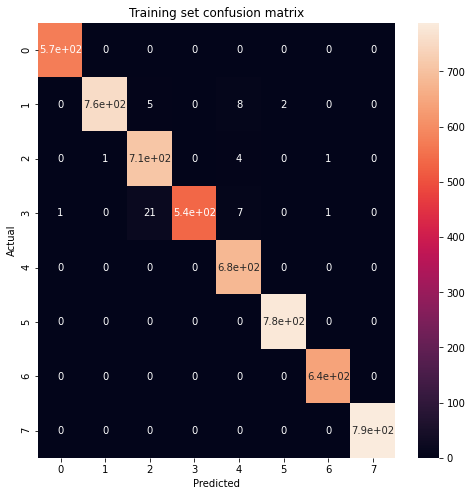

In [12]:
conf_mat=confusion_matrix(act_labels,pred_labels)
fig_size=(8,8)
fig,ax=plt.subplots(figsize=fig_size)
hm=sns.heatmap(conf_mat,annot=True,ax=ax)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Training set confusion matrix')
plt.show()

In [13]:
print("Predicted testing labels:",pred_labels_t)
print("Shape:",pred_labels_t.shape)
print("Actual testing labels:",act_labels_t)
print("Shape:",act_labels_t.shape)


Predicted testing labels: tensor([0, 1, 4,  ..., 7, 5, 2])
Shape: torch.Size([1379])
Actual testing labels: tensor([0, 1, 0,  ..., 7, 5, 3])
Shape: torch.Size([1379])


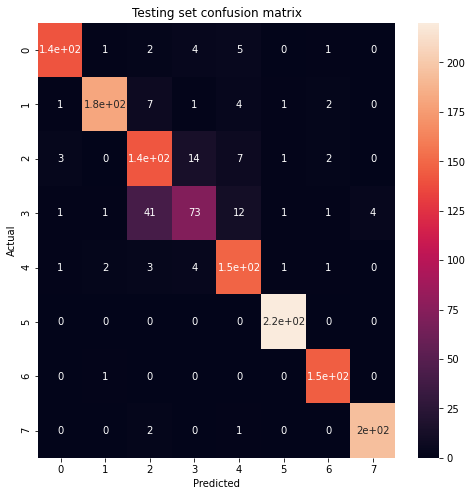

In [14]:
conf_mat=confusion_matrix(act_labels_t,pred_labels_t)
fig_size=(8,8)
fig,ax=plt.subplots(figsize=fig_size)
hm=sns.heatmap(conf_mat,annot=True,ax=ax)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Testing set confusion matrix')
plt.show()